In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle
from scipy.io import savemat, loadmat

In [2]:
# load weights and bias
file_name_AE="./model/AE_v2_swish.p"

AE = pickle.load(open(file_name_AE,'rb'))

en_w1=AE['en_w1']
en_b1=AE['en_b1']
en_w2=AE['en_w2']
de_w1=AE['de_w1']
de_w2=AE['de_w2']
de_w1T=AE['de_w1T']
de_w2T=AE['de_w2T']
de_w2_sp=AE['de_w2_sp']
de_w2T_sp=AE['de_w2T_sp']

m, M2 = de_w2.shape
f = de_w1.shape[1]

In [3]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_np_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)  
    return y

def decoder_np_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = dout.dot(de_w2T)   
    return y,dydxT.T

def decoder_sp_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)
    return y

def decoder_sp_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
    return y,dydxT.T

# NM-ROM (g) ~ $O(fmM_2)$, where $M_2$ is the number of nodes in a hidden layer of a fully dense decoder

# If a masked decoder, $O(fM_2)+O(fm^2)$, where $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [4]:
def residual_hat(u_hatn,u_hatw,uw,c,Jg_pinv,idxn1):
    
    # \hat r = -\hat u^n + \hat u^{n+1} - dt*J_g^{\dagger}f(g(\hat u^{n+1}))   
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r_hat = -u_hatn + u_hatw + Jg_pinv.dot(f)
    
    return r_hat

In [5]:
def jacobian_hat(u,c,Jg_pinv,Jg,idxn1,I_hat):
    
    # \hat J = \hat I - dtJg+JfJg
    
    diag_comp = c*(2*u - u[idxn1])
    diag_out = (diag_comp*Jg.T).T
    
    subdiag_comp = -c*u[1:]
    subdiag_out = (subdiag_comp*Jg[:-1].T).T
    
    top_row = -c*u[0]*Jg[-1]
    
    JfJg = diag_out
    JfJg[1:] += subdiag_out
    JfJg[0] += top_row

    J_hat = I_hat + (Jg_pinv@JfJg)
    
    return J_hat


amp=0.6

Time elapsed: 1.8953967094421387 sec
average relative error: 1.7880416283716667%
maximum relative error: 2.9893351219802753%


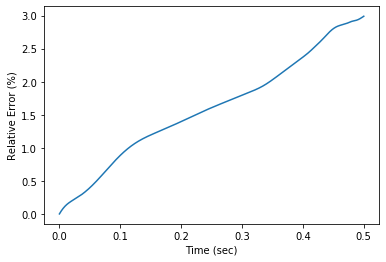


amp=0.62

Time elapsed: 2.2750282287597656 sec
average relative error: 1.6468608866812173%
maximum relative error: 2.755304267725165%


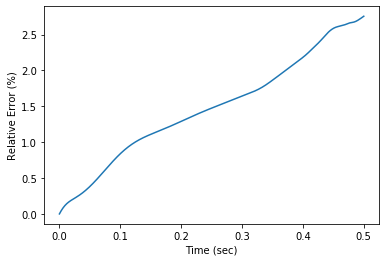


amp=0.64

Time elapsed: 2.407999038696289 sec
average relative error: 1.5130070811840965%
maximum relative error: 2.5324898934109963%


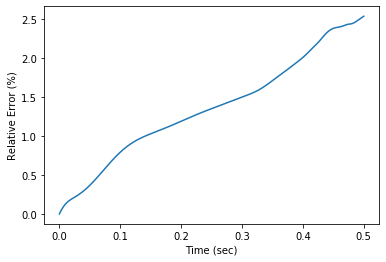


amp=0.66

Time elapsed: 2.3650002479553223 sec
average relative error: 1.3865042967796233%
maximum relative error: 2.3193319248894135%


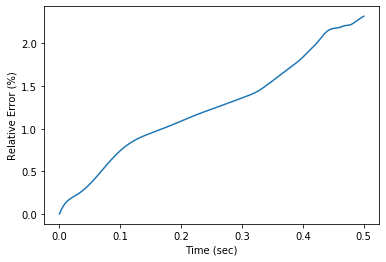


amp=0.68

Time elapsed: 2.4439988136291504 sec
average relative error: 1.267329834889427%
maximum relative error: 2.116023061576114%


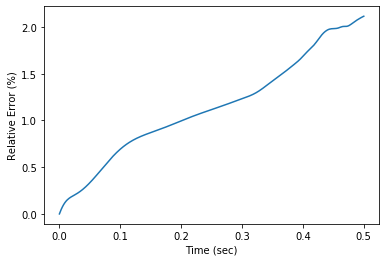


amp=0.7

Time elapsed: 2.5119996070861816 sec
average relative error: 1.155400799416538%
maximum relative error: 1.9197147464830837%


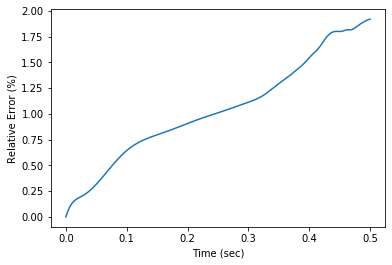


amp=0.72

Time elapsed: 2.4049975872039795 sec
average relative error: 1.0504931259297967%
maximum relative error: 1.7313138075406818%


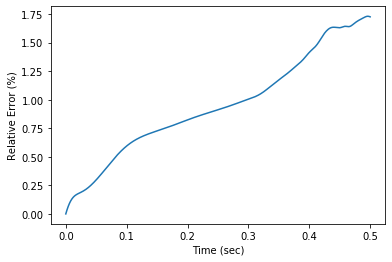


amp=0.74

Time elapsed: 2.5189974308013916 sec
average relative error: 0.9523662446811847%
maximum relative error: 1.557085722754903%


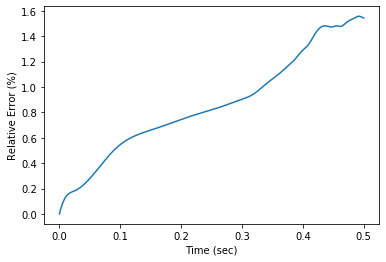


amp=0.76

Time elapsed: 2.4989981651306152 sec
average relative error: 0.8609141401388551%
maximum relative error: 1.3962251509477683%


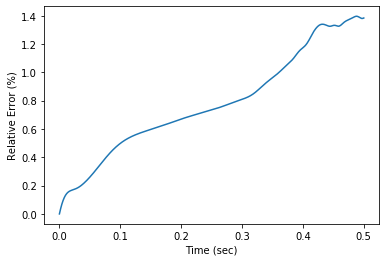


amp=0.78

Time elapsed: 2.478999376296997 sec
average relative error: 0.7759634632934964%
maximum relative error: 1.247799372390726%


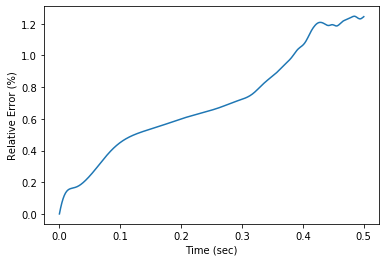

In [6]:
ampArr = np.array([0.6,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98,1.0,\
                   1.02,1.04,1.06,1.08,1.1,1.12,1.14,1.16,1.18,1.2])
num_amp = ampArr.shape[0]
resultArrGalerkin = np.zeros((num_amp,4))

for ii in range(num_amp):
    # load FOM solution
    amp=ampArr[ii]
    print()
    print('amp={}'.format(amp))
    file_name_FOM="./data/FOM_amp_{}.p".format(amp)
    u=pickle.load(open(file_name_FOM,'rb'))
    
    # set parameters
    width = 1.0

    convergence_threshold = 1.0e-5
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 500
    dt = 0.5 / nt  

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1=np.zeros(nx-1,dtype='int')
    idxn1[1:]=np.arange(nx-2)
    idxn1[0]=nx-2

    u0 = np.copy(u[0])
    u_hat0=np.zeros(f,dtype='float32')
    
    # Run ROM
    t_total_rom_g_start=time.time()

    u_rom_g = np.zeros((nt+1,nx),dtype='float32')
    u_rom_g[0] = u0.astype('float32')
    u_hat = np.zeros((nt+1,f),dtype='float32')
    u_hat[0] = u_hat0
    I_hat = np.eye(f,dtype='float32')
    for n in range(nt): 
    #     print("")
    #     print(n,"th time step:")
        u_hatw = u_hat[n].copy()

        uw, Jg = decoder_sp_forward_backward(u_hatw)
        uw += u0[:-1]

        Jg_pinv = np.linalg.pinv(Jg)
        r_hat = residual_hat(u_hat[n],u_hatw,uw,c,Jg_pinv,idxn1)

        for k in range(maxk):   
            J_hat = jacobian_hat(uw,c,Jg_pinv,Jg,idxn1,I_hat)

            du_hatw = np.linalg.solve(J_hat,-r_hat) 
            u_hatw = u_hatw + du_hatw

            uw, Jg = decoder_sp_forward_backward(u_hatw)
            uw += u0[:-1]

            Jg_pinv = np.linalg.pinv(Jg)
            r_hat = residual_hat(u_hat[n],u_hatw,uw,c,Jg_pinv,idxn1)

            res = np.linalg.norm(r_hat)

    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))
            if res < convergence_threshold:
                u_hat[n+1] = u_hatw.copy()
                u_rom_g[n+1,:-1] = uw.copy()
                u_rom_g[n+1,-1] = u_rom_g[n+1,0]
                break

        if res >= convergence_threshold:
    #         print("\n non converged after {}th iteration".format(maxk))
#             break
            u_hat[n+1] = u_hatw.copy()
            u_rom_g[n+1,:-1] = uw.copy()
            u_rom_g[n+1,-1] = u_rom_g[n+1,0]

#         u_hat[n+1] = u_hatw.copy()
#         u_rom_g[n+1,:-1] = uw.copy()
#         u_rom_g[n+1,-1] = u_rom_g[n+1,0]

    t_total_rom_g=time.time()-t_total_rom_g_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_g))

    # Compute errors
    rel_err=np.linalg.norm(u-u_rom_g,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)     

    print("average relative error: {}%".format(avg_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))

    plt.plot(dt*np.arange(nt+1),rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.show()

    # save results
    resultArrGalerkin[ii]=[amp,t_total_rom_g,avg_rel_err,max_rel_err]   

# NM-ROM (lspg) ~ $O(fmM_2)$, where $M_2$ is the number of nodes in a hidden layer of a fully dense decoder

# If a masked decoder, $O(fM_2)$, where $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [7]:
def residual_lspg(uwn,uw,c,idxn1):
    
    f = c*(uw**2 - uw*uw[idxn1])
    
    r = -uwn + uw + f
    
    return r

In [8]:
def jacobian_lspg(u,c,Jg,idxn1):
    
    # J \approx J_g - \Delta t J_f J_g = (I-\delta t J_f)J_g
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    diag_out = (diag_comp*Jg.T).T
    
    subdiag_comp = -c*u[1:]
    subdiag_out = (subdiag_comp*Jg[:-1].T).T
    
    top_row = -c*u[0]*Jg[-1]
    
    J = diag_out
    J[1:] += subdiag_out
    J[0] += top_row
    
    return J


amp=0.6

Time elapsed: 1.6999974250793457 sec
average relative error: 2.51312225987686%
maximum relative error: 4.373668522287209%


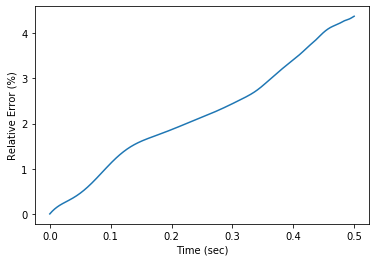


amp=0.62

Time elapsed: 1.6659982204437256 sec
average relative error: 2.320231515846293%
maximum relative error: 4.026165322662589%


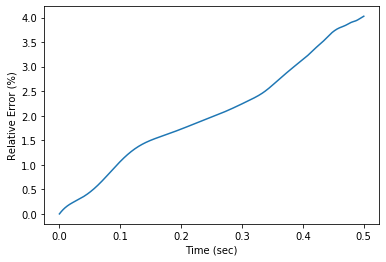


amp=0.64

Time elapsed: 1.7229983806610107 sec
average relative error: 2.134630990510231%
maximum relative error: 3.6942367051743403%


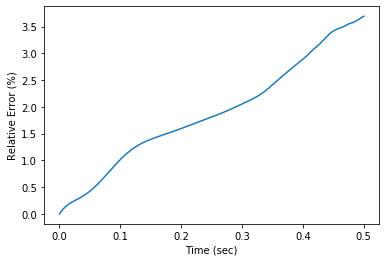


amp=0.66

Time elapsed: 1.6809988021850586 sec
average relative error: 1.9567988879135978%
maximum relative error: 3.378450855219061%


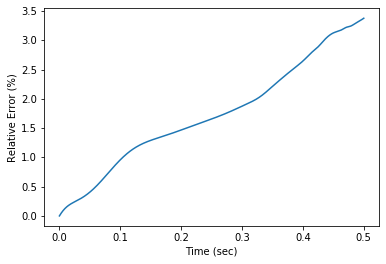


amp=0.68

Time elapsed: 1.6749985218048096 sec
average relative error: 1.7870865475789441%
maximum relative error: 3.0800228299317687%


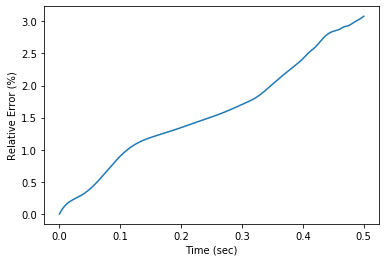


amp=0.7

Time elapsed: 1.6879985332489014 sec
average relative error: 1.6257574854545813%
maximum relative error: 2.79705067080904%


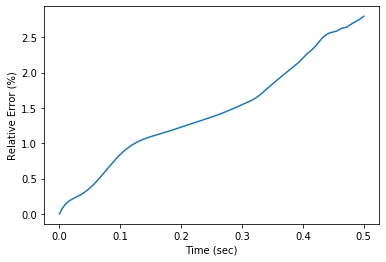


amp=0.72

Time elapsed: 1.6809914112091064 sec
average relative error: 1.4728883741329775%
maximum relative error: 2.5208411126384256%


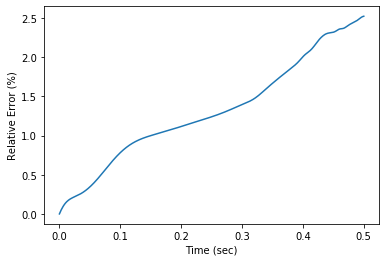


amp=0.74

Time elapsed: 1.7249979972839355 sec
average relative error: 1.3284096796700702%
maximum relative error: 2.253976757181124%


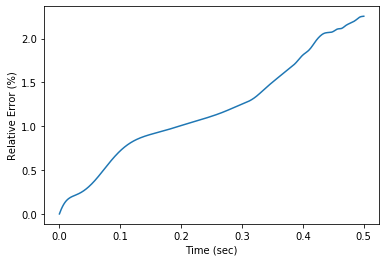


amp=0.76

Time elapsed: 1.616002082824707 sec
average relative error: 1.1922423326439497%
maximum relative error: 2.008474418362508%


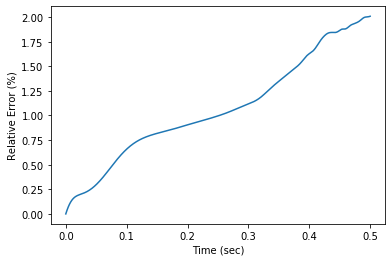


amp=0.78

Time elapsed: 1.7399985790252686 sec
average relative error: 1.0643337519845781%
maximum relative error: 1.7870225027235669%


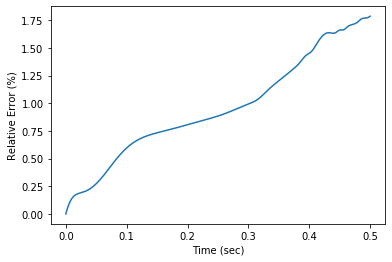

In [9]:
ampArr = np.array([0.6,0.62,0.64,0.66,0.68,0.70,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98,1.0,\
                   1.02,1.04,1.06,1.08,1.1,1.12,1.14,1.16,1.18,1.2])
num_amp=ampArr.shape[0]
resultArrLSPG=np.zeros((num_amp,4))

for ii in range(num_amp):
    # load FOM solution
    amp=ampArr[ii]
    print()
    print('amp={}'.format(amp))
    file_name_FOM="./data/FOM_amp_{}.p".format(amp)
    u=pickle.load(open(file_name_FOM,'rb'))
    
    # set parameters
    width = 1.0

    convergence_threshold = 1.0e-5
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 500
    dt = 0.5 / nt  

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1=np.zeros(nx-1,dtype='int')
    idxn1[1:]=np.arange(nx-2)
    idxn1[0]=nx-2

    u0 = np.copy(u[0])
    u_hat0=np.zeros(f,dtype='float32')
    
    # Run ROM
    t_total_rom_lspg_start=time.time()

    u_rom_lspg = np.zeros((nt+1,nx),dtype='float32')
    u_rom_lspg[0] = u0.astype('float32')
    u_hat = np.zeros((nt+1,f),dtype='float32')
    u_hat[0] = u_hat0
    I_hat = np.eye(f,dtype='float32')
    for n in range(nt): 
    #     print("")
    #     print(n,"th time step:")
        u_hatw = u_hat[n].copy()

        uw, Jg = decoder_sp_forward_backward(u_hatw)
        uw += u0[:-1]

        J_lspg = jacobian_lspg(uw,c,Jg,idxn1)

        r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
        r = r_lspg.dot(J_lspg)

        for k in range(maxk):   
            J = J_lspg.T.dot(J_lspg)

            du_hatw = np.linalg.solve(J,-r)

            u_hatw = u_hatw + du_hatw

            uw, Jg = decoder_sp_forward_backward(u_hatw)        
            uw += u0[:-1]

            J_lspg = jacobian_lspg(uw,c,Jg,idxn1)

            r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
            r = r_lspg.dot(J_lspg)

            res = np.linalg.norm(r)
    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

            if res < convergence_threshold:            
                u_hat[n+1] = u_hatw.copy()
                u_rom_lspg[n+1,:-1] = uw.copy()
                u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]
                break

        if res >= convergence_threshold:
    #         print("\n non converged after {}th iteration".format(maxk))
#             break
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg[n+1,:-1] = uw.copy()
            u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]

#         u_hat[n+1] = u_hatw.copy()
#         u_rom_lspg[n+1,:-1] = uw.copy()
#         u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]

    t_total_rom_lspg=time.time()-t_total_rom_lspg_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_lspg))

    # Compute errors
    rel_err=np.linalg.norm(u-u_rom_lspg,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)     

    print("average relative error: {}%".format(avg_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))

    plt.plot(dt*np.arange(nt+1),rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.show()

    # save results
    resultArrLSPG[ii]=[amp,t_total_rom_lspg,avg_rel_err,max_rel_err]   

# Plots

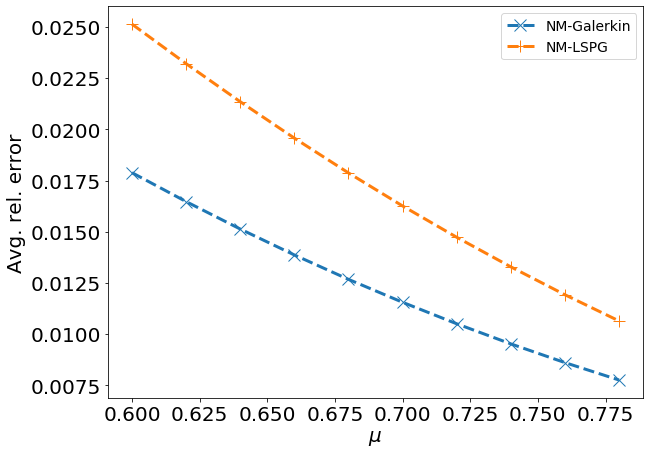

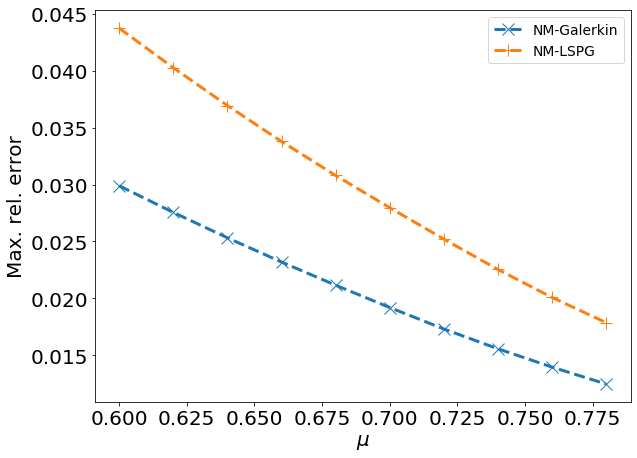

In [10]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-2],'x--',ampArr,1e-2*resultArrLSPG[:,-2],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Avg. rel. error')
plt.legend(['NM-Galerkin','NM-LSPG'],fontsize='x-small')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArrGalerkin[:,-1],'x--',ampArr,1e-2*resultArrLSPG[:,-1],'+--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error')
plt.legend(['NM-Galerkin','NM-LSPG'],fontsize='x-small')
plt.show()

In [11]:
print('NM-LSPG')
print()
ampArr = resultArrLSPG[:,0]
namp=ampArr.shape[0]
print('{:^6}\t{:^12}\t{:^12}\t{:^12}'.format('param','time_elapsed','avg_rel_err','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    time_elapsed=resultArrLSPG[iii,1]
    avg_rel_err=resultArrLSPG[iii,2]
    max_rel_err=resultArrLSPG[iii,3]
    
    print('{:^6.2f}\t{:^12.2f}\t{:^12.2f}\t{:^12.2f}'.format(amp,time_elapsed,avg_rel_err,max_rel_err))

NM-LSPG

param 	time_elapsed	avg_rel_err 	max_rel_err 
 0.60 	    1.70    	    2.51    	    4.37    
 0.62 	    1.67    	    2.32    	    4.03    
 0.64 	    1.72    	    2.13    	    3.69    
 0.66 	    1.68    	    1.96    	    3.38    
 0.68 	    1.67    	    1.79    	    3.08    
 0.70 	    1.69    	    1.63    	    2.80    
 0.72 	    1.68    	    1.47    	    2.52    
 0.74 	    1.72    	    1.33    	    2.25    
 0.76 	    1.62    	    1.19    	    2.01    
 0.78 	    1.74    	    1.06    	    1.79    


In [12]:
print('NM-Galerkin')
print()
ampArr = resultArrGalerkin[:,0]
namp=ampArr.shape[0]
print('{:^6}\t{:^12}\t{:^12}\t{:^12}'.format('param','time_elapsed','avg_rel_err','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    time_elapsed=resultArrGalerkin[iii,1]
    avg_rel_err=resultArrGalerkin[iii,2]
    max_rel_err=resultArrGalerkin[iii,3]
    
    print('{:^6.2f}\t{:^12.2f}\t{:^12.2f}\t{:^12.2f}'.format(amp,time_elapsed,avg_rel_err,max_rel_err))

NM-Galerkin

param 	time_elapsed	avg_rel_err 	max_rel_err 
 0.60 	    1.90    	    1.79    	    2.99    
 0.62 	    2.28    	    1.65    	    2.76    
 0.64 	    2.41    	    1.51    	    2.53    
 0.66 	    2.37    	    1.39    	    2.32    
 0.68 	    2.44    	    1.27    	    2.12    
 0.70 	    2.51    	    1.16    	    1.92    
 0.72 	    2.40    	    1.05    	    1.73    
 0.74 	    2.52    	    0.95    	    1.56    
 0.76 	    2.50    	    0.86    	    1.40    
 0.78 	    2.48    	    0.78    	    1.25    


# Save

In [13]:
resultDic={'LSPG':resultArrLSPG,'Galerkin':resultArrGalerkin}
pickle.dump(resultDic,open('./data/prediction_NM-ROM.p','wb'))
savemat('./data/prediction_NM-ROM.mat',resultDic)